In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("masterdbFromRobMac.xlsx",  index_col=0)

In [3]:
df.head()

,commentId,dataSource,NumberFromRawData,comment,rating,Survey N,Question N,q1p1,q1p2,q2p1,...,P2QualScore,Q1Match,Q2Match,Q3Match,perfectMatch,RobMacCommentModified,RobMacQ1,RobMacQ2,RobMacQ3,RobMacQualScore
7,7,Sas,8,The trainee had all the appropriate things re...,5.0,1,8,3,2,2,...,3,False,True,False,False,The trainee had all the appropriate things re...,1.0,0.0,0.0,1.0
35,35,Sas,36,Thorough assessments and good clinical judgmen...,5.0,1,36,3,2,2,...,2,False,True,True,False,Thorough assessments and good clinical judgmen...,1.0,0.0,0.0,1.0
74,74,Sas,75,the trainee uses EDUS appropriately and with ...,5.0,2,25,1,2,2,...,2,False,True,True,False,the trainee uses EDUS appropriately and with ...,1.0,0.0,0.0,1.0
86,86,Sas,87,required prompting optho treatment. Eye rinse ...,3.0,2,37,3,2,2,...,2,False,True,True,False,required prompting optho treatment. Eye rinse ...,1.0,0.0,0.0,1.0
88,88,Sas,89,Very good image generation and interpretations...,4.0,2,39,1,2,2,...,2,False,True,True,False,Very good image generation and interpretations...,1.0,0.0,0.0,1.0


In [4]:
#First let's merge initial scoring and  Rob and Mac's overrides.
#This algo will ignore Rob and Mac's overrides on Perfect matches. As there was a mistake on previous document and probably wrong scoring


dPerfect = df[df['perfectMatch'] == True ]

dPerfect.shape


(1074, 30)

In [5]:
dNonPerfect = df[df['perfectMatch'] == False ]

dNonPerfect.shape


(1426, 30)

In [6]:
print( dPerfect.shape[0] + dNonPerfect.shape[0])


2500


In [7]:
df['Q1'] = dNonPerfect['RobMacQ1']
df['Q2'] = dNonPerfect['RobMacQ2']
df['Q3'] = dNonPerfect['RobMacQ3']
df['QUAL'] = dNonPerfect['RobMacQualScore']

#now fill the blanks from the original ratings.
# it does not matter getting P1 or P2 score as they are perfect match

df['Q1'].fillna(dPerfect['q1p1T'], inplace=True)
df['Q2'].fillna(dPerfect['q2p1T'], inplace=True)
df['Q3'].fillna(dPerfect['q3p1T'], inplace=True)
df['QUAL'].fillna(dPerfect['P1QualScore'], inplace=True)



In [8]:
import numpy as np


#calculate sum of qual scores and compare with the previous manually summed values to determine if they check out.
df['summedQs'] = df['Q1']+df['Q2']+df['Q3']

comparison_QUALScore_columns = np.where(df['summedQs'] == df['QUAL'], True, False)

df["isQUALequal"] = comparison_QUALScore_columns

df["isQUALequal"].value_counts()

True     2497
False       3
Name: isQUALequal, dtype: int64

In [9]:
#It seems that 3 qual scores sums do not check out. Let's replace them with actual calculation

df.loc[(df.isQUALequal == False),'QUAL'] = df['summedQs']

In [10]:
# let's drop summedQs and isQUALequal after checkking those values to avoid confusion.

df.drop(['summedQs', 'isQUALequal'], axis=1, inplace=True)

In [11]:
df['Q1'].value_counts()

3.0    1262
2.0     774
1.0     359
0.0     105
Name: Q1, dtype: int64

In [12]:
df['Q2'].value_counts()

0.0    2016
1.0     484
Name: Q2, dtype: int64

In [13]:
df['Q3'].value_counts()

0.0    2075
1.0     425
Name: Q3, dtype: int64

In [14]:
df['QUAL'].value_counts().sort_index()

0.0    100
1.0    338
2.0    685
3.0    957
4.0     77
5.0    343
Name: QUAL, dtype: int64

In [15]:
df['QUAL'].value_counts(normalize=True).sort_index()

0.0    0.0400
1.0    0.1352
2.0    0.2740
3.0    0.3828
4.0    0.0308
5.0    0.1372
Name: QUAL, dtype: float64

<AxesSubplot:>

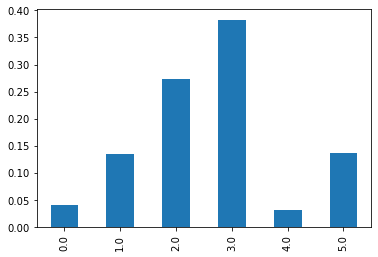

In [16]:
df['QUAL'].value_counts(normalize=True).sort_index().plot(kind='bar')

# df['QUAL'].value_counts().sort_index().plot(kind='pie')

In [17]:
df[['Q1', 'Q2', 'Q3', 'QUAL']].describe().T

,count,mean,std,min,25%,50%,75%,max
Q1,2500.0,2.2772,0.860149,0.0,2.0,3.0,3.0,3.0
Q2,2500.0,0.1936,0.395198,0.0,0.0,0.0,0.0,1.0
Q3,2500.0,0.1700,0.375708,0.0,0.0,0.0,0.0,1.0
QUAL,2500.0,2.6408,1.275157,0.0,2.0,3.0,3.0,5.0


In [22]:
df['feedbackWordCount'] = df['RobMacCommentModified'].str.split().str.len()

df['feedbackCharCount'] = df['RobMacCommentModified'].str.len()

df['feedbackWordCount'].fillna(0, inplace=True)

df['feedbackCharCount'].fillna(0, inplace=True)

count    2500.000000
mean       33.868400
std        46.932736
min         0.000000
25%         9.000000
50%        17.000000
75%        38.000000
max       457.000000
Name: feedbackWordCount, dtype: float64

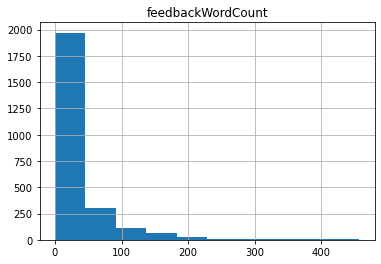

In [39]:
df['feedbackWordCount'].value_counts().sort_index()

df.hist(column='feedbackWordCount')

df['feedbackWordCount'].describe()

In [21]:
#lets create a masterDB for NLP use and only get the final data to be used in analaysis.

dfForNLP = df[['commentId', 'dataSource', 'NumberFromRawData', 'RobMacCommentModified',
                                                             #we will get Rob's edited comments 
                                                            #as they made the final decision on it.
               'rating', 'Survey N', 'Question N',
               'Q1', 'Q2', 'Q3', 'QUAL',
               'feedbackWordCount', 'feedbackCharCount',
              
              ]].copy()

dfForNLP.rename(columns = {'RobMacCommentModified':'feedback', 'commentId':'rawCommentId'}, inplace = True)

df.to_excel("masterDbTextPreProcessed.xlsx")
dfForNLP.to_excel("masterDbforNLPAnalysis.xlsx")